**This notebook generates two new features (SoF, has_blocker) and adds them to model_v1, fits a CPH model, views performance with multiple model setting**

In [1]:
import pandas as pd
import numpy as np
import math
import statistics
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'whitegrid', palette = 'dark')

from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import survival_difference_at_fixed_point_in_time_test
from lifelines import CoxPHFitter

from sklearn.model_selection import train_test_split
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

import scipy.stats as stats
from scipy.spatial import distance
from scipy.spatial import cKDTree
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.spatial import ConvexHull, Delaunay
from scipy.spatial.distance import euclidean

import get_data
import tackle_plot

import warnings
warnings.filterwarnings('ignore')
%load_ext autoreload
%autoreload 2

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [2]:
def plot(gameId, playId):
    game = get_data.game(gameId)
    play = get_data.play(gameId, playId)
    tracking = get_data.tracking(gameId, playId).reset_index()
    
    date = game['gameDate'].item()
    tacklers = get_data.tacklers(gameId, playId)
    carrier = play['ballCarrierId'].item()
    offence = play['possessionTeam'].item()
    defence = play['defensiveTeam'].item()
    down = play['down'].item()
    yardstogo = play['yardsToGo'].item()
    ablos = play['absoluteYardlineNumber'].item()   
    
    fig0, fig = tackle_plot.plot(tracking, date, tacklers, carrier, offence, defence, down, yardstogo, ablos) 
    
    fig0.show(config={'displayModeBar': False})    
    fig.show(config={'displayModeBar': False})

In [3]:
games_all = pd.read_csv('../rawdata/games.csv')
tackles_all = pd.read_csv('../rawdata/tackles.csv')
players_all = pd.read_csv('../rawdata/players.csv')
plays_all = pd.read_csv('../rawdata/plays.csv')

In [4]:
tracking_data = {}
for i in range(9):
    w = i + 1
    tracking_data[w] = pd.read_csv(f'../rawdata/tracking_week_{w}.csv')

### Prepare dataset

Dataset 'plays_tackle' was generated in 'data_overview', merged from play data and tackle data, only including 'pass short' play, with certain abnormal data removed.

In [5]:
plays_tackle = pd.read_csv('../newdata/plays_tackle.csv')
plays_tackle = plays_tackle.drop_duplicates(subset = ['gameId', 'playId'], keep = 'first').reset_index(drop = True)
plays_tackle.shape

(5024, 42)

## Generate new feature variables

Following the model design in 'preliminary_model', I created two new features:

- **SoF**

SoF (sum of freedom) - A measure of area to quantify how free the ball carrier can move under defense team's pressure, calculated using a Voronoi graph. In my calculation, the free area is enclosed by the Voronoi ridges between carrier and his neighbor defenders, restrained by certain boundaries. 'neighbor defenders' are identified using the Voronoi graph. Within the free area, the forward half A_fw should weigh more than the backward half A_bw. The equation of SoF is defined as: SoF = log(A_bw + 1) + A_fw. 

- **has_blocker**

has_blocker - A binary variable indicating if any offense player other than the carrier is inside the significant area. The significant area is defined by: the convex hull of the carrier and all the neighbor defenders if the defender is not behind the carrier for more than 5 yards. 5 is an arbireary choice.

In [6]:
def standardize_tracking(tracking):
    """
    Standardize data so all plays are seen as played from left to right

    Parameters:
    df1 (DataFrame): tracking data of one selected play.
    Returns:
    df1 (DataFrame): standardized tracking data of one selected play.
    """
    tracking['x'] = 120-tracking['x']
    tracking['y'] = 53.3-tracking['y']  
    tracking['dir'] = (tracking['dir'] + 180) % 360
    tracking['o'] = (tracking['o'] + 180) % 360
    return tracking

In [7]:
def get_neighbors(points, target_point):
    """
    Identify the neighboring points of a given target point within a Voronoi diagram. The neighbors are identified 
    based on the Voronoi ridges between the target point and its adjacent points.

    Args:
    points (np.ndarray): A numpy array of points [[x1, y1], [x2, y2], ...], including the target point.
    target_point (np.ndarray): A numpy array representing the target point [x, y].

    Returns:
    np.ndarray: A numpy array of the neighboring points to the target point including the target point.

    """
    target_idx = np.where((points == target_point).all(axis=1))[0][0]
    vor = Voronoi(points)
    neighbor_indices = [i for i in range(len(points)) if 
                vor.ridge_points[np.isin(vor.ridge_points, target_idx).any(1)].flatten().tolist().count(i) > 0]  
    vor_np_n = points[neighbor_indices]
    return vor_np_n

In [8]:
def order_polygon_points(points):
    """
    Order a numpy array representing a polygon's coordinates.

    Args:
    points (np.ndarray): A numpy array of points [[x1, y1], [x2, y2], ...] as the polygon's vertices.

    Returns:
    np.ndarray: The ordered coordinates of the polygon.
    """
    # Calculate centroid
    centroid_x = np.mean(points[:, 0])
    centroid_y = np.mean(points[:, 1])

    # Sort the points based on angle from centroid
    sorted_points = sorted(points, key=lambda point: math.atan2(point[1] - centroid_y, point[0] - centroid_x))

    return np.array(sorted_points)

In [9]:
def get_vertices(points, target_point):
    """
    Computes and orders the vertices of the Voronoi cell corresponding to a specified point.

    Args:
    points (np.ndarray): An ORDERED numpy array of points [[x1, y1], [x2, y2], ...] as the polygon's vertices.
    target_point (np.ndarray): A numpy array representing the target point [x, y].

    Returns:
    np.ndarray: An ordered numpy array of the vertices.
    """
    vor = Voronoi(points)    
    vertices = vor.vertices
    
    target_point_idx = np.where((points == target_point).all(axis=1))[0][0]
    region_index = vor.point_region[target_point_idx]
    region_vertices = vor.regions[region_index]
    vertices = np.array([v for i,v in enumerate(vertices) if i in region_vertices])
    vertices = order_polygon_points(vertices)
    
    return vertices    

In [10]:
def get_intersections(points, x_value):
    """
    Find the intersection points of a polygon with a vertical line x = x_value.

    Args:
    points (np.ndarray): An ORDERED numpy array of points [[x1, y1], [x2, y2], ...] as the polygon's vertices, known
    that x_value is between the min and max x values of points.
    x_value (float): The x-value of the vertical line.

    Returns:
    numpy array: The intersection points with the line x = x_value.
    """
    intersections = []

    for i in range(len(points)):
        start, end = points[i], points[(i + 1) % len(points)]

        if (start[0] <= x_value and end[0] >= x_value) or (end[0] <= x_value and start[0] >= x_value):
            if start[0] == end[0]: 
                if start[0] == x_value:
                    intersections.append([start, end])
            else:
                t = (x_value - start[0]) / (end[0] - start[0])
                y_intersect = start[1] + t * (end[1] - start[1])
                intersections.append([x_value, y_intersect])

    if len(intersections) != 2:
        raise Exception("number of intersections not equal to two")

    return np.array(intersections)

In [11]:
def calculate_area(points):
    """
    Calculate the area of a polygon given its vertices using shoelace formula.
    
    Args:
    points (np.ndarray): An ORDERED numpy array of points [[x1, y1], [x2, y2], ...] as the polygon's vertices.

    Returns:
    float: The area of the polygon.
    """
    n = len(points)  
    area = 0.0

    for i in range(n):
        j = (i + 1) % n  
        area += points[i][0] * points[j][1]
        area -= points[j][0] * points[i][1]

    area = abs(area) / 2.0
    return area

In [12]:
def get_areas(points, target_point):
    """
    Calculates the areas of the sub polygons formed by dividing a polygon with a vertical line through a given point.

    Args:
    points (np.ndarray): A numpy array of points [[x1, y1], [x2, y2], ...] as the polygon's vertices, known that 
    the target_point is within the polygon.
    target_point (np.ndarray): A numpy array representing the target point [x, y].

    Returns:
    tuple: A tuple containing the area of the left polygon, the area of the right polygon, 
           vertices of the left polygon, and vertices of the right polygon.
    """
    intersections =  get_intersections(points, target_point[0])
    
    points_right = np.array([p for p in points if p[0] > target_point[0]])
    points_right = np.vstack([points_right, intersections])
    points_right = order_polygon_points(points_right)
    area_right = calculate_area(points_right)
    
    points_left = np.array([p for p in points if p[0] < target_point[0]])
    points_left = np.vstack([points_left, intersections])
    points_left = order_polygon_points(points_left)
    area_left = calculate_area(points_left)    
    
    return area_left, area_right, points_left, points_right

In [13]:
def check_blocker(hull_points, checked_points):
    """
    Determines if any points in a set of checked_points lie within the convex hull defined by another set of points.

    Parameters:
    hull_points (np.ndarray): An array of points [[x1, y1], [x2, y2], ...] used to construct the convex hull.
    checked_points (np.ndarray): A numpy array of points [[x1, y1], [x2, y2], ...]
    
    Returns:
    bool: True if any of the checked_points lie within the convex hull, False otherwise.
    """
    #returns False if there are less than three unique points in 'hull_points', as a convex hull cannot be formed.
    if len(np.unique(hull_points, axis=0)) < 3:
        return False

    hull = ConvexHull(hull_points)
    tri = Delaunay(hull_points[hull.vertices])
    return any(np.array([tri.find_simplex(p) >=0 for p in checked_points]))

In [14]:
def plot_polygon(coordinates, color='grey', alpha = 0.5):
    '''
    Fill a polygon in a plot.
    '''
    x, y = zip(*coordinates)
    x += (x[0],)
    y += (y[0],)

    plt.fill(x, y, color=color, alpha=alpha) 

In [15]:
def plot_vor(points_nbs, hull_points, carrier_caught_xy, boundary_points, vertices, 
             vertices_left, vertices_right, offense_caught_xy_n):
    """
    Creates a plot of a Voronoi diagram with additional features including hulls, carriers, boundaries, and vertices.

    Args:
    points_nbs (np.ndarray): An array of points used to generate the Voronoi diagram.
    hull_points (np.ndarray): Points used to create a convex hull, if possible.
    carrier_caught_xy (np.ndarray): The position of the ball carrier.
    boundary_points (np.ndarray): Points that define the boundary of the area of interest.
    vertices (np.ndarray): Vertices of the Voronoi cell associated with the ball carrier.
    vertices_left (np.ndarray): Vertices of the left section of the divided Voronoi cell.
    vertices_right (np.ndarray): Vertices of the right section of the divided Voronoi cell.
    offense_caught_xy_n (np.ndarray): Positions of the offenders.

    Returns:
    None: The function creates and displays a plot.
    """
    fig, ax = plt.subplots(figsize = (6,6))
    
    vor = Voronoi(points_nbs)
    voronoi_plot_2d(vor, ax=ax, show_vertices=False, line_colors='dimgrey', line_width=1)
    
    # Separate defender points from carrier and boundary points
    defense_nbs_xy = np.array([p for i, p in enumerate(points_nbs) if 
                      not np.any((p == np.vstack([boundary_points, carrier_caught_xy])).all(axis = 1))])
    
    points_plot = np.vstack([vertices, defense_nbs_xy])
    max_y = np.max(points_plot[:, 1])
    min_y = np.min(points_plot[:, 1])
    max_x = np.max(points_plot[:, 0])
    min_x = np.min(points_plot[:, 0])
    
    ylim_top = max_y + 5 if max_y <= 48.3 else 53.3
    ylim_bot = min_y - 5 if min_y >= 5 else 0

    plt.plot(defense_nbs_xy[:, 0], defense_nbs_xy[:, 1], 'o', color = 'darkblue', label = 'defenders')
    plt.plot(carrier_caught_xy[0], carrier_caught_xy[1], 'o', color = 'sienna', label = 'ball carrier')   
    plt.plot(boundary_points[:, 0], boundary_points[:, 1], 'o', color = 'lightgrey')  
    plt.plot(vertices[:, 0], vertices[:, 1], 'o', color = 'black', markersize = 3)
    plt.plot(offense_caught_xy_n[:, 0], offense_caught_xy_n[:, 1], 'o', color = 'peru', 
             markersize = 3.5, label = 'offenders')

    if len(np.unique(hull_points, axis=0)) >= 3:
        hull = ConvexHull(hull_points)      
        for simplex in hull.simplices:
            plt.plot(hull_points[simplex, 0], hull_points[simplex, 1], linestyle=':', color = 'grey')
    
    plot_polygon(vertices_right, alpha = 0.5)
    plot_polygon(vertices_left, alpha = 0.2)
    
    ax.set_ylim(ylim_bot, ylim_top)
    ax.set_xlim(min_x-5, max_x+5)
    ax.set_aspect('equal')
    ax.grid(False) 
    
    plt.legend(bbox_to_anchor =(1.02, 0.8), loc='upper left') 
    plt.show()

In [16]:
import voronoi_mod
for idx, row in plays_tackle[:4].iterrows():
    gameId, playId = row['gameId'], row['playId']
    game_week = games_all[games_all['gameId'] == gameId]['week'].item()
    carrier = row['ballCarrierId']
    offense = row['possessionTeam']
    defense = row['defensiveTeam']
    
    tracking_w = tracking_data[game_week]
    tracking = tracking_w[(tracking_w['gameId'] == gameId) & (tracking_w['playId'] == playId)].reset_index(drop = True)
    if tracking.at[0, 'playDirection'] == 'left':
        tracking = standardize_tracking(tracking)
    
    caught_frm = 6
    # Note the special case
    if gameId == 2022110608 and playId == 2351:
        caught_frm = 32
        
    caught_df = tracking[tracking['frameId'] == caught_frm]
    
    defense_caught_df = caught_df[caught_df['club'] == defense].reset_index(drop = True)
    defense_caught_xy = defense_caught_df[['x', 'y']].to_numpy()
    
    carrier_caught_df = caught_df[caught_df['nflId'] == carrier]
    carrier_caught_xy = carrier_caught_df[['x', 'y']].to_numpy()[0]

    # Set boundary points to avoid unbounded vertices. The points are either mirrored from carrier across 
    # the sidelines or 40 yards from the carrier on both xy directions.
    boundary_points = np.array(
        [[carrier_caught_xy[0], 53.3+(53.3-carrier_caught_xy[1])], 
         [carrier_caught_xy[0], 0-carrier_caught_xy[1]],
         [carrier_caught_xy[0], carrier_caught_xy[1]+40],
         [carrier_caught_xy[0], carrier_caught_xy[1]-40],
         [carrier_caught_xy[0] - 40, carrier_caught_xy[1]], 
         [carrier_caught_xy[0] + 40, carrier_caught_xy[1]]] ) 
    
    points = np.vstack([defense_caught_xy, carrier_caught_xy, boundary_points])
    
    # Get neighbor defenders from all points
    points_nbs = get_neighbors(points, carrier_caught_xy)
    vertices = get_vertices(points_nbs, carrier_caught_xy)
    
    # Get areas and calculate SoF
    area_left, area_right, vertices_left, vertices_right = get_areas(vertices, carrier_caught_xy) 
    log_area_left = np.log(area_left+1)
    SoF = log_area_left + area_right
    
    # Get offense players other than the carrier
    offense_caught_df = caught_df[caught_df['club'] == offense].reset_index(drop = True)
    offense_caught_xy = offense_caught_df[['x', 'y']].to_numpy()   
    offense_caught_xy_n = np.array([p for i, p in enumerate(offense_caught_xy) if np.any(p != carrier_caught_xy)])    
    
    # Get defender points which are not 5 yards behind carrier    
    hull_points = np.array([p for i, p in enumerate(points_nbs) if 
                  not np.any((p == boundary_points).all(axis = 1))          
                  and p[0] > carrier_caught_xy[0] - 5])
    fig = voronoi_mod.plot_vor(points_nbs, hull_points, carrier_caught_xy, boundary_points, vertices, 
             vertices_left, vertices_right, offense_caught_xy_n)
    fig.show()

Sample graphs:
gameId:2022100908, playId:3537, has_blocker:False
area_left: 15.36, log(area_left+1): 2.79, area_right: 23.85, SoF: 26.64


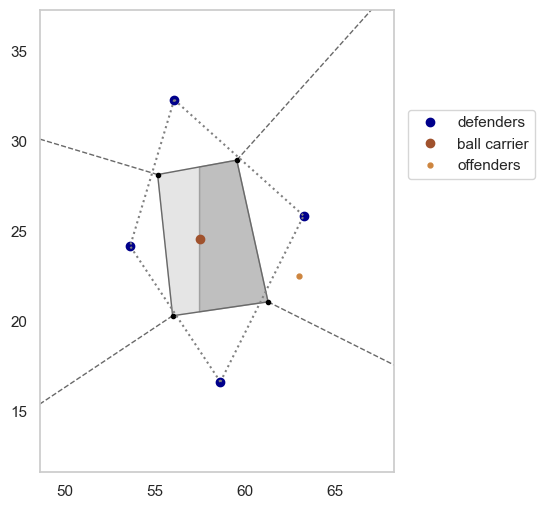

gameId:2022091111, playId:1148, has_blocker:False
area_left: 16.47, log(area_left+1): 2.86, area_right: 11.15, SoF: 14.02


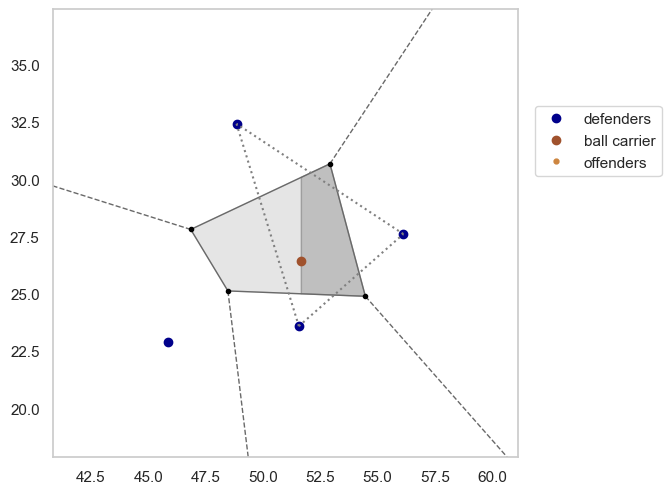

gameId:2022103001, playId:2165, has_blocker:True
area_left: 445.2, log(area_left+1): 6.1, area_right: 180.18, SoF: 186.28


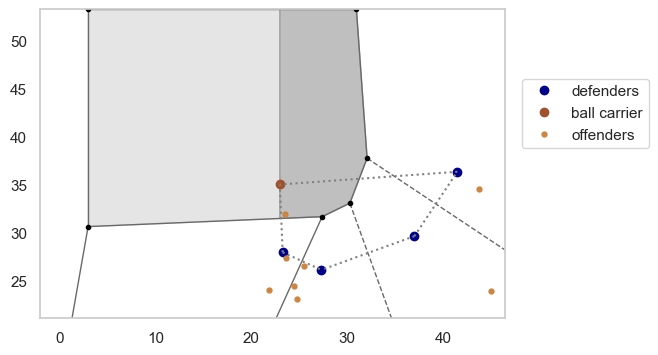

gameId:2022092511, playId:2903, has_blocker:True
area_left: 255.73, log(area_left+1): 5.55, area_right: 12.8, SoF: 18.35


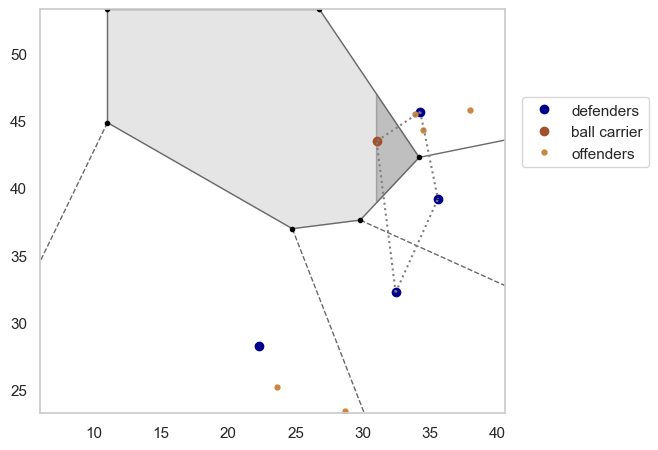

gameId:2022091102, playId:3336, has_blocker:False
area_left: 0.84, log(area_left+1): 0.61, area_right: 7.97, SoF: 8.58


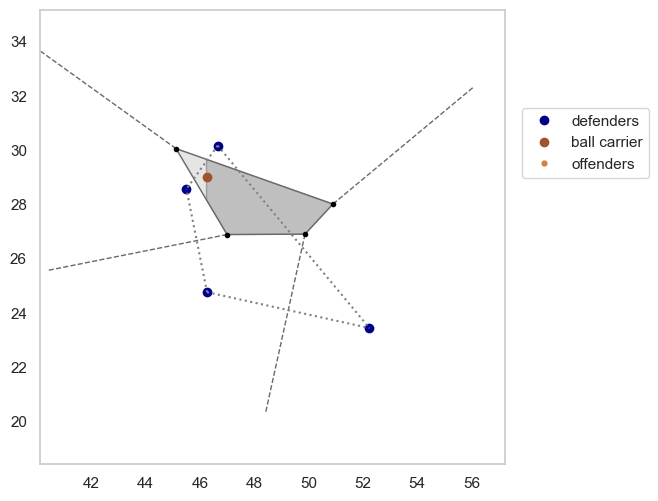

gameId:2022100212, playId:1183, has_blocker:True
area_left: 52.39, log(area_left+1): 3.98, area_right: 15.11, SoF: 19.09


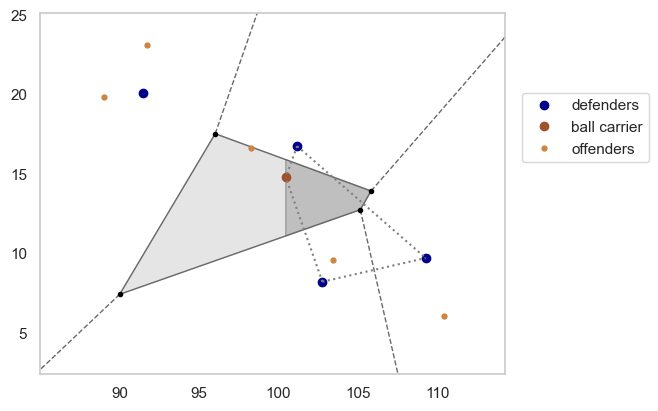

gameId:2022102303, playId:1895, has_blocker:False
area_left: 5.7, log(area_left+1): 1.9, area_right: 24.8, SoF: 26.7


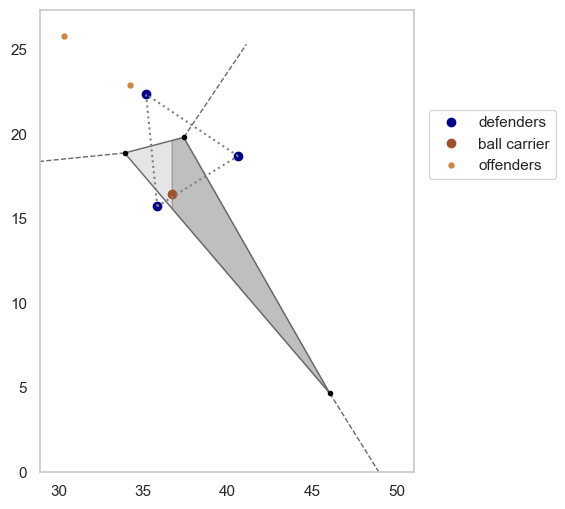

gameId:2022110603, playId:3498, has_blocker:False
area_left: 291.51, log(area_left+1): 5.68, area_right: 7.66, SoF: 13.34


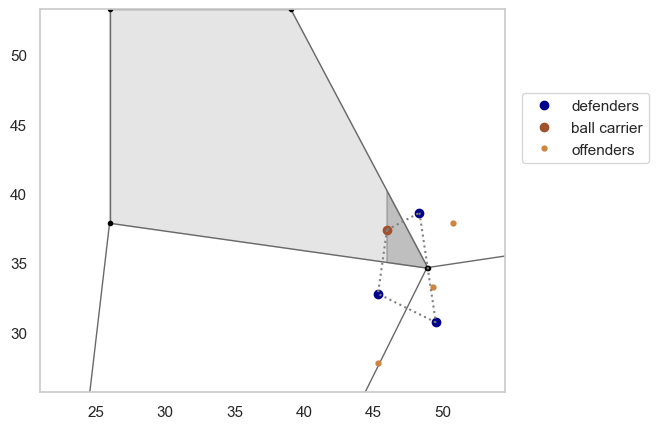

gameId:2022100211, playId:1790, has_blocker:True
area_left: 264.24, log(area_left+1): 5.58, area_right: 21.86, SoF: 27.44


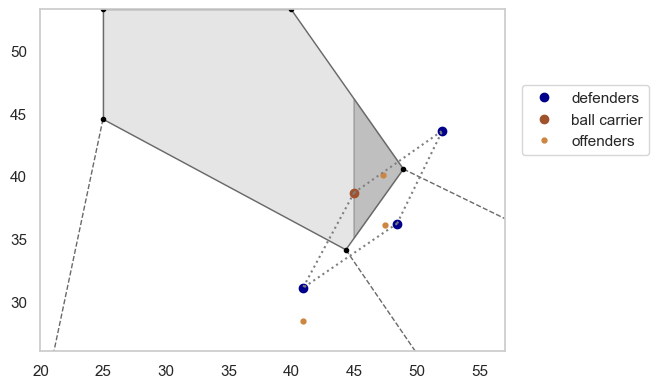

gameId:2022102305, playId:1996, has_blocker:False
area_left: 85.43, log(area_left+1): 4.46, area_right: 20.56, SoF: 25.02


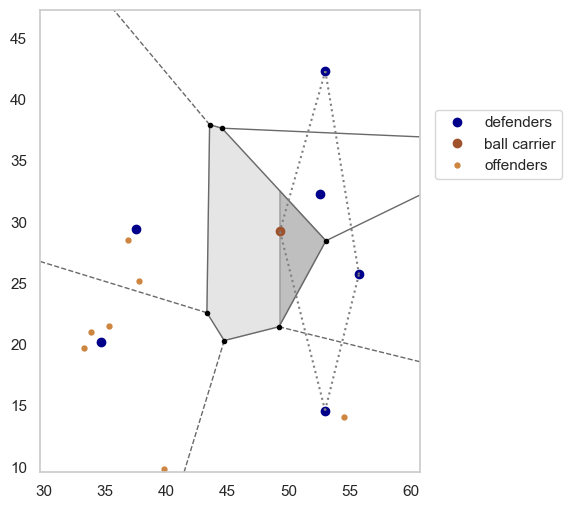

gameId:2022091109, playId:1705, has_blocker:False
area_left: 216.37, log(area_left+1): 5.38, area_right: 46.02, SoF: 51.4


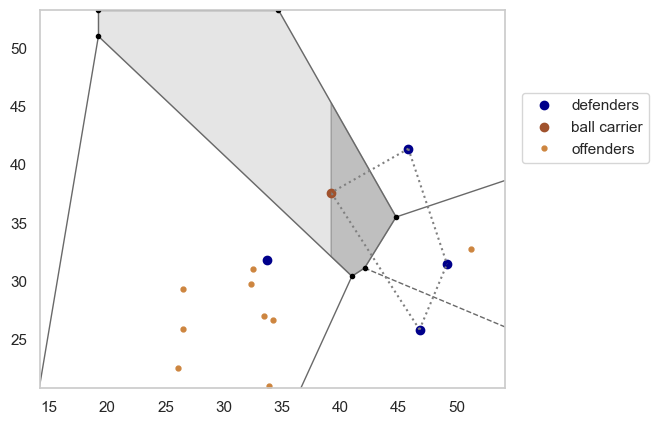

CPU times: total: 1min 16s
Wall time: 55.7 s


In [17]:
%%time
freedom_data = []
print('Sample graphs:')

for idx, row in plays_tackle.iterrows():
    gameId, playId = row['gameId'], row['playId']
    game_week = games_all[games_all['gameId'] == gameId]['week'].item()
    carrier = row['ballCarrierId']
    offense = row['possessionTeam']
    defense = row['defensiveTeam']
    
    tracking_w = tracking_data[game_week]
    tracking = tracking_w[(tracking_w['gameId'] == gameId) & (tracking_w['playId'] == playId)].reset_index(drop = True)
    if tracking.at[0, 'playDirection'] == 'left':
        tracking = standardize_tracking(tracking)
    
    caught_frm = 6
    # Note the special case
    if gameId == 2022110608 and playId == 2351:
        caught_frm = 32
        
    caught_df = tracking[tracking['frameId'] == caught_frm]
    
    defense_caught_df = caught_df[caught_df['club'] == defense].reset_index(drop = True)
    defense_caught_xy = defense_caught_df[['x', 'y']].to_numpy()
    
    carrier_caught_df = caught_df[caught_df['nflId'] == carrier]
    carrier_caught_xy = carrier_caught_df[['x', 'y']].to_numpy()[0]

    # Set boundary points to avoid unbounded vertices. The points are either mirrored from carrier across 
    # the sidelines or 40 yards from the carrier on both xy directions.
    boundary_points = np.array(
        [[carrier_caught_xy[0], 53.3+(53.3-carrier_caught_xy[1])], 
         [carrier_caught_xy[0], 0-carrier_caught_xy[1]],
         [carrier_caught_xy[0], carrier_caught_xy[1]+40],
         [carrier_caught_xy[0], carrier_caught_xy[1]-40],
         [carrier_caught_xy[0] - 40, carrier_caught_xy[1]], 
         [carrier_caught_xy[0] + 40, carrier_caught_xy[1]]] ) 
    
    points = np.vstack([defense_caught_xy, carrier_caught_xy, boundary_points])
    
    # Get neighbor defenders from all points
    points_nbs = get_neighbors(points, carrier_caught_xy)
    vertices = get_vertices(points_nbs, carrier_caught_xy)
    
    # Get areas and calculate SoF
    area_left, area_right, vertices_left, vertices_right = get_areas(vertices, carrier_caught_xy) 
    log_area_left = np.log(area_left+1)
    SoF = log_area_left + area_right
    
    # Get offense players other than the carrier
    offense_caught_df = caught_df[caught_df['club'] == offense].reset_index(drop = True)
    offense_caught_xy = offense_caught_df[['x', 'y']].to_numpy()   
    offense_caught_xy_n = np.array([p for i, p in enumerate(offense_caught_xy) if np.any(p != carrier_caught_xy)])    
    
    # Get defender points which are not 5 yards behind carrier    
    hull_points = np.array([p for i, p in enumerate(points_nbs) if 
                  not np.any((p == boundary_points).all(axis = 1))          
                  and p[0] > carrier_caught_xy[0] - 5])
    
    # Get the binary variable has_blocker
    has_blocker = check_blocker(hull_points, offense_caught_xy_n)
    
    freedom_data.append({'gameId':gameId, 'playId':playId, 'area_left':area_left, 'log_area_left': log_area_left,
                            'area_right': area_right, 'SoF': SoF, 'has_blocker': has_blocker})
    
    # Display sample graphs
    if idx <=10:
        print(f'gameId:{gameId}, playId:{playId}, has_blocker:{has_blocker}')
        print(f'area_left: {area_left.round(2)}, log(area_left+1): {log_area_left.round(2)}, area_right: {area_right.round(2)}, SoF: {SoF.round(2)}')
        plot_vor(points_nbs, hull_points, carrier_caught_xy, boundary_points, vertices, 
             vertices_left, vertices_right, offense_caught_xy_n)

freedom_df = pd.DataFrame(freedom_data)

In [18]:
freedom_df['has_blocker'] = freedom_df['has_blocker'].apply(lambda x: 1 if x == True else 0)

In [19]:
freedom_df.describe()

gameId       playId    area_left  log_area_left   area_right  \
count  5.024000e+03  5024.000000  5024.000000    5024.000000  5024.000000   
mean   2.022099e+09  1997.484275   151.114362       4.538508    34.555690   
std    5.938008e+03  1180.772543   118.618340       1.178605    37.499399   
min    2.022091e+09    54.000000     0.083959       0.080620     0.203140   
25%    2.022092e+09   972.500000    40.135183       3.716864    11.035319   
50%    2.022101e+09  1975.500000   135.538138       4.916604    23.207911   
75%    2.022102e+09  3001.000000   239.533605       5.482860    44.241730   
max    2.022111e+09  5096.000000   578.499025       6.362164   465.962703   

               SoF  has_blocker  
count  5024.000000  5024.000000  
mean     39.094197     0.221139  
std      37.712023     0.415055  
min       2.228922     0.000000  
25%      15.484145     0.000000  
50%      27.856244     0.000000  
75%      49.281764     0.000000  
max     471.181825     1.000000

## Combine all variables and fit CPH model

In [20]:
progress_df2 = pd.read_csv('../newdata/progress_df2.csv')

In [21]:
progress_df2.shape

(5024, 11)

In [22]:
progress_df3 = pd.merge(progress_df2, freedom_df[['gameId', 'playId', 'SoF', 'has_blocker']], 
                     on = ['gameId', 'playId'], how = 'left')

In [23]:
progress_df3.head()

gameId  playId  progress  lst_event  near_defender  near_defender_MPD  \
0  2022100908    3537  2.340000          1        43306.0           0.318461   
1  2022091111    1148  2.779999          1        47843.0           0.831594   
2  2022103001    2165  9.760002          1        46205.0           3.444545   
3  2022092511    2903  6.030006          1        52527.0           2.751467   
4  2022091102    3336  0.777499          1        46077.0           0.735391   

   near_dist  leverage  caught_width   caught_x play_direct         SoF  \
0   3.881714         0          2.07  57.560001        left   26.639809   
1   2.832137         1          0.23  51.650002       right   14.015269   
2   7.086353         0         18.29  23.480000       right  186.281002   
3   3.919005         0          9.83  31.449997        left   18.348826   
4   0.860930         0         24.29  48.610001       right    8.584447   

   has_blocker  
0            0  
1            0  
2            1  
3            1  
4            0

In [24]:
progress_df3.to_csv('../newdata/progress_df3.csv', index = False)

In [25]:
model_df = progress_df3[['lst_event', 'progress', 'near_defender_MPD', 'near_dist', 
                         'leverage', 'caught_width', 'SoF', 'has_blocker']]

In [26]:
scaler = StandardScaler()
standardized_df = pd.DataFrame(scaler.fit_transform(model_df), columns = model_df.columns)
standardized_df.cov()

lst_event  progress  near_defender_MPD  near_dist  \
lst_event           1.000199 -0.141075          -0.049681  -0.020245   
progress           -0.141075  1.000199           0.420751   0.428282   
near_defender_MPD  -0.049681  0.420751           1.000199   0.511977   
near_dist          -0.020245  0.428282           0.511977   1.000199   
leverage           -0.004592 -0.058165          -0.060021  -0.058576   
caught_width       -0.010591 -0.006025          -0.020775  -0.005997   
SoF                -0.079944  0.361678           0.325232   0.446050   
has_blocker        -0.018003  0.298356           0.239871   0.222645   

                   leverage  caught_width       SoF  has_blocker  
lst_event         -0.004592     -0.010591 -0.079944    -0.018003  
progress          -0.058165     -0.006025  0.361678     0.298356  
near_defender_MPD -0.060021     -0.020775  0.325232     0.239871  
near_dist         -0.058576     -0.005997  0.446050     0.222645  
leverage           1.000199     -0.007269 -0.162027     0.018948  
caught_width      -0.007269      1.000199 -0.020872    -0.032538  
SoF               -0.162027     -0.020872  1.000199     0.083674  
has_blocker        0.018948     -0.032538  0.083674     1.000199

In [27]:
mask = np.random.rand(len(model_df)) < 0.75
df_train = model_df[mask]
df_test = model_df[~mask]

In [28]:
cph_model = CoxPHFitter()
cph_model.fit(df=df_train, duration_col='progress', event_col='lst_event')
cph_model.print_summary()

<lifelines.CoxPHFitter: fitted with 3799 total observations, 94 right-censored observations>
             duration col = 'progress'
                event col = 'lst_event'
      baseline estimation = breslow
   number of observations = 3799
number of events observed = 3705
   partial log-likelihood = -26226.37
         time fit was run = 2024-01-09 00:18:35 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
near_defender_MPD  -0.12       0.88       0.01            -0.14            -0.10                 0.87                 0.90
near_dist          -0.11       0.89       0.01            -0.13            -0.10                 0.88                 0.91
leverage           -0.04       0.96       0.03            -0.11             0.02                 0.89                 1.02
caught_width       -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
SoF                -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
has_blocker        -0.54       0.58       0.04            -0.62            -0.46                 0.54                 0.63

                    cmp to      z      p   -log2(p)
covariate                                          
near_defender_MPD     0.00 -11.16 <0.005      93.67
near_dist             0.00 -12.13 <0.005     110.09
leverage              0.00  -1.29   0.20       2.33
caught_width          0.00  -0.87   0.39       1.37
SoF                   0.00 -10.67 <0.005      85.84
has_blocker           0.00 -12.84 <0.005     123.01
---
Concordance = 0.75
Partial AIC = 52464.75
log-likelihood ratio test = 1389.90 on 6 df
-log2(p) of ll-ratio test = 984.71

The model summary suggests that:
    
- Indicated by high '-log2(p)' value and low p-value, features 'near_defender_MPD', 'near_dist', 'SoF', and 'has_blocker' all have a significant negative impact on the hazard (occurrence of a dead ball). Negative coef indicates that as the values of these variables increase, the likelihood of the event happening decreases.   

- 'Leverage' and 'caught_with' do not show a statistically significant effect.

- The concordance index of 0.75 suggests the model has good yet not perfect predictive power. 

- the high overall -log2(p) suggests the overall model is statistically significant.

<Axes: xlabel='log(HR) (95% CI)'>

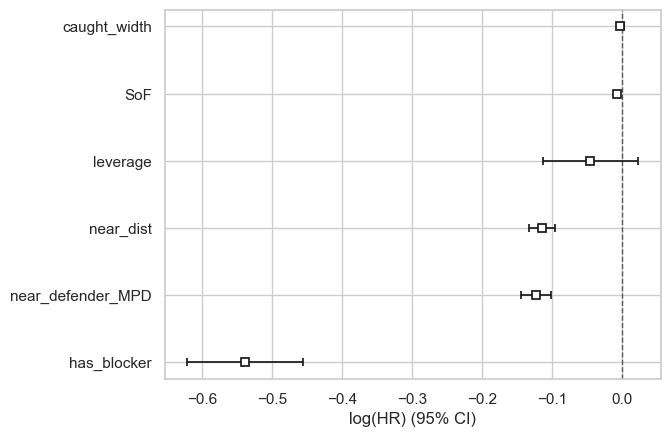

In [29]:
cph_model.plot()

In [30]:
model_df['leverage'].value_counts()

leverage
0    3215
1    1809
Name: count, dtype: int64

In [31]:
model_df[['near_defender_MPD', 'near_dist', 'leverage', 'caught_width', 'SoF']].cov()

near_defender_MPD  near_dist  leverage  caught_width  \
near_defender_MPD           4.156261   2.567403 -0.058731     -0.290284   
near_dist                   2.567403   6.052818 -0.069170     -0.101130   
leverage                   -0.058731  -0.069170  0.230466     -0.023918   
caught_width               -0.290284  -0.101130 -0.023918     46.993859   
SoF                        24.999874  41.376655 -2.932802     -5.394759   

                           SoF  
near_defender_MPD    24.999874  
near_dist            41.376655  
leverage             -2.932802  
caught_width         -5.394759  
SoF                1422.196649

In [32]:
quartiles = model_df[['near_defender_MPD', 'near_dist', 'caught_width', 'SoF']].quantile([0.05, 0.50, 0.95]).round(2)

In [33]:
quartiles

near_defender_MPD  near_dist  caught_width     SoF
0.05               0.08       0.56          2.23    7.17
0.50               0.76       3.01         13.32   27.86
0.95               6.07       8.16         24.66  109.02

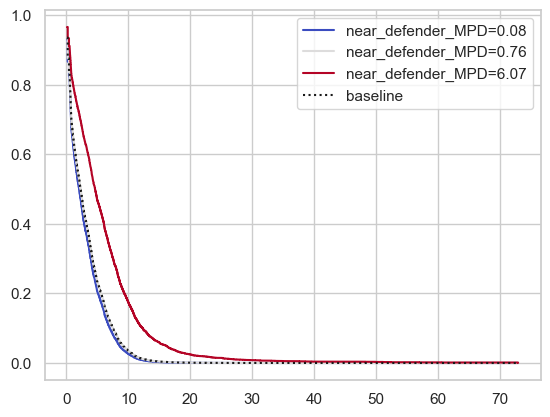

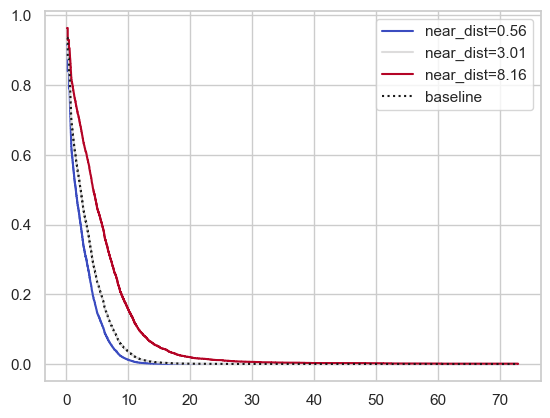

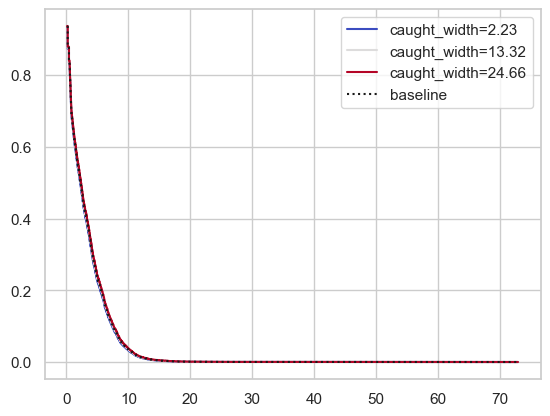

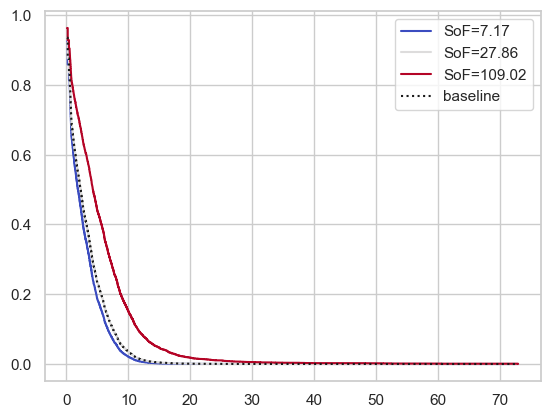

In [34]:
for col in quartiles.columns:
    cph_model.plot_partial_effects_on_outcome(covariates = col, values = quartiles[col].tolist(), cmap = 'coolwarm')   

<Axes: >

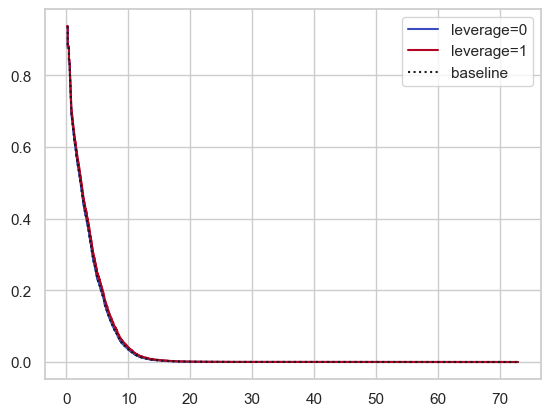

In [35]:
cph_model.plot_partial_effects_on_outcome(covariates = 'leverage', values = [0,1], cmap = 'coolwarm')

<Axes: >

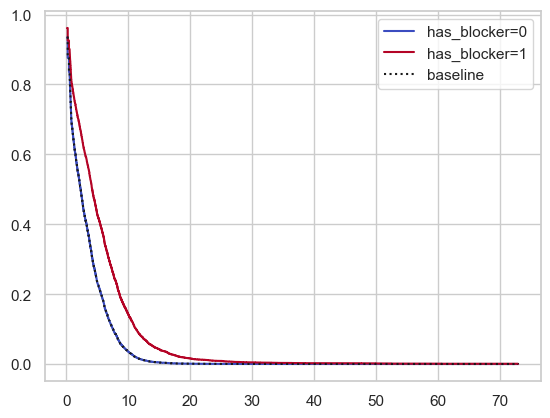

In [36]:
cph_model.plot_partial_effects_on_outcome(covariates = 'has_blocker', values = [0,1], cmap = 'coolwarm')

## Compare predicted probability distribution and rsme between different model setting

The survival analysis models were designed to generate survival functions, which predict the probability of event occurrence not before certain durations. To understand the prediction pattern of fitted models, I set the model to generate a survival function for each case in the test data, and then from the survival function retrieved the probability of the play achieving the true progress from data. The model's prediction pattern can be viewed from the distribution of predicted probability. Meanwhile, although CoxPH model is not typically used for predicting the exact survival duration, it can provided predicted duration as a side reference.

In [37]:
def fit_predict(model_df, robust = False):
    '''
    Trains a Cox Proportional Hazards model on specified dataset, evaluates its performance on a test set, 
    and visualizes the results.

    Args:
    - model_df (DataFrame): The input dataframe for modeling.
    - robust (bool, optional): If True, a robust fitting approach is used. Default is False.
    '''    
    
    mask = np.random.rand(len(model_df)) < 0.75
    df_train = model_df[mask]
    df_test = model_df[~mask].reset_index(drop = True)
    
    cph_model = CoxPHFitter()
    cph_model.fit(df=df_train, duration_col='progress', event_col='lst_event', robust = robust)
    cph_model.print_summary()
    
    df_predict = predict_prob_cph(cph_model, df_test)
    plot_prob(df_predict)
    
    # Predict progress and plot error
    df_predict['ex_progress'] = cph_model.predict_expectation(df_test)
    df_predict['error'] = df_predict['ex_progress'] - df_predict['progress']
    rmse = np.sqrt(mean_squared_error(df_predict['progress'], df_predict['ex_progress']))
    print(f'rmse: {rmse}')
    plt.figure(figsize=(12, 3))
    sns.scatterplot(data = df_predict, x = 'progress', y = 'error', s = 5)
    plt.show()

In [38]:
def plot_prob(df_predict):
    '''
    Generates two plots to visualize the predicted probabilities: a histogram and a scatter plot.

    Args:
    - df_predict (DataFrame): The dataframe containing the 'Predicted_Probability' and 'progress' columns.
    '''
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 5]})

    # Histogram of Predicted Probabilities
    n, bins, patches = ax1.hist(df_predict['Predicted_Probability'], bins=6, alpha=0.7)
    ax1.set_title('Histogram of Predicted Probabilities')
    ax1.set_xlabel('Predicted Probability')
    ax1.set_ylabel('Frequency')

    for i in range(len(patches)):
        ax1.text(patches[i].xy[0] + patches[i].get_width() / 2, patches[i].get_height(), 
                 f'{n[i]/len(df_predict):.2f}', ha='center', va='bottom')
        
    # Scatter Plot of Predicted Probabilities vs Progress
    sns.scatterplot(data=df_predict, x='progress', y='Predicted_Probability', s=5, ax=ax2)
    ax2.set_title('CPH Model - Scatter Plot of Predicted Probabilities vs Progress')
    ax2.set_xlabel('Progress')
    ax2.set_ylabel('Predicted Probability')
    
    ax2.set_xticks(np.arange(0, max(df_predict.progress), 5))

    plt.tight_layout()
    plt.show()

In [39]:
def predict_prob_cph(model, df_test):
    '''
    Generates predicted probabilities for a test dataset using a Cox Proportional Hazards model.

    Args:
    - model (CoxPHFitter object): The fitted Cox Proportional Hazards model.
    - df_test (DataFrame): The test dataframe containing the features and 'progress' column.

    Returns:
    DataFrame: A copy of the test dataframe with an additional 'Predicted_Probability' column, 
               containing the predicted probabilities rounded to two decimal places.    
    '''
    df_predict = df_test.copy()
    predictions = []
    for index, row in df_predict.iterrows():

        progress = math.floor(row['progress']*10)/10
        data = row.drop(['progress', 'lst_event'])  

        survival_function = model.predict_survival_function(data)
        progress = survival_function.index[abs(progress - survival_function.index).argmin()]

        predicted_probability = survival_function.loc[progress, index]
        predictions.append(predicted_probability)

    df_predict['Predicted_Probability'] = predictions
    df_predict['Predicted_Probability'] = df_predict['Predicted_Probability'].round(2)   
    return df_predict

<lifelines.CoxPHFitter: fitted with 3793 total observations, 90 right-censored observations>
             duration col = 'progress'
                event col = 'lst_event'
      baseline estimation = breslow
   number of observations = 3793
number of events observed = 3703
   partial log-likelihood = -26177.76
         time fit was run = 2024-01-09 00:18:38 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
near_defender_MPD  -0.13       0.88       0.01            -0.15            -0.10                 0.86                 0.90
near_dist          -0.11       0.90       0.01            -0.13            -0.09                 0.88                 0.91
leverage           -0.06       0.94       0.04            -0.13             0.01                 0.88                 1.01
caught_width       -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
SoF                -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
has_blocker        -0.53       0.59       0.04            -0.61            -0.45                 0.54                 0.64

                    cmp to      z      p   -log2(p)
covariate                                          
near_defender_MPD     0.00 -11.78 <0.005     104.06
near_dist             0.00 -11.92 <0.005     106.37
leverage              0.00  -1.76   0.08       3.69
caught_width          0.00  -2.20   0.03       5.17
SoF                   0.00 -12.37 <0.005     114.40
has_blocker           0.00 -12.95 <0.005     124.97
---
Concordance = 0.75
Partial AIC = 52367.53
log-likelihood ratio test = 1433.25 on 6 df
-log2(p) of ll-ratio test = 1015.89

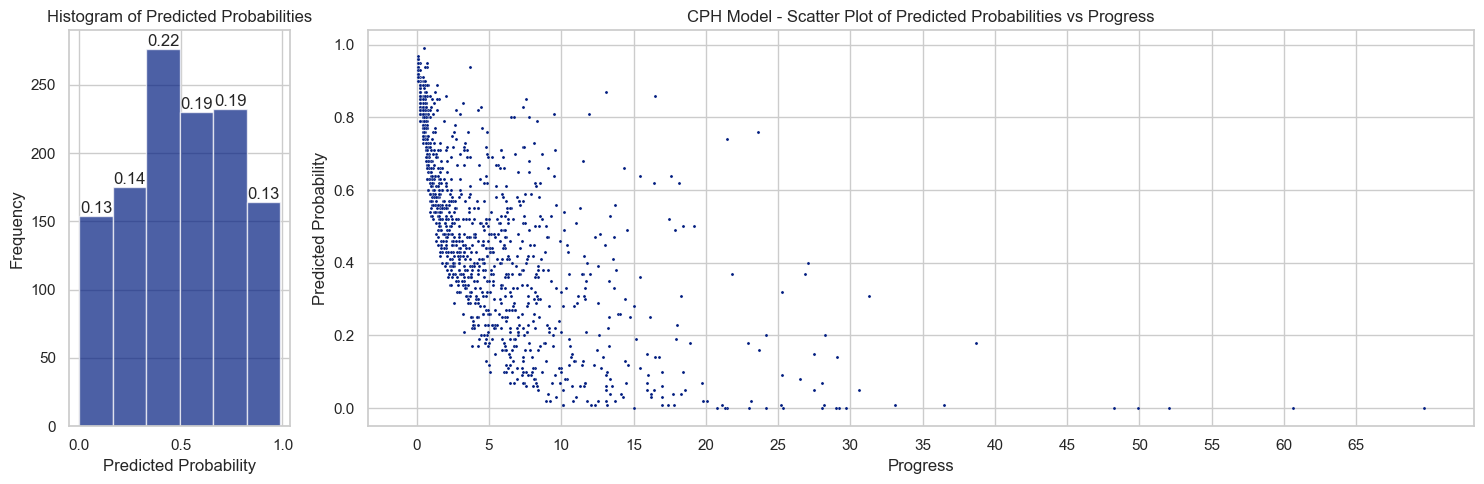

rmse: 6.866516651392122


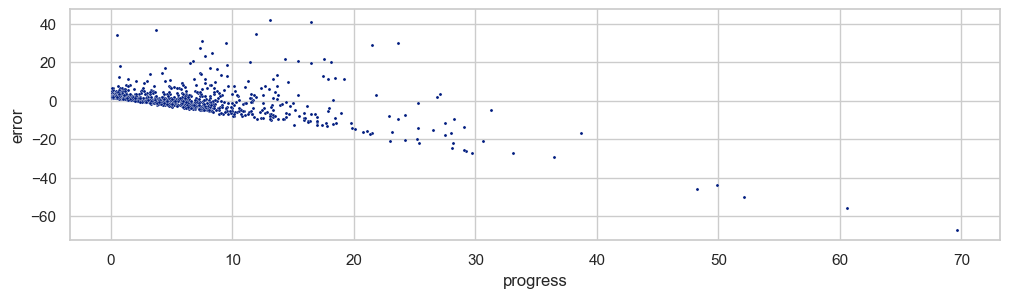

In [40]:
fit_predict(model_df, robust = False)

<lifelines.CoxPHFitter: fitted with 3822 total observations, 98 right-censored observations>
             duration col = 'progress'
                event col = 'lst_event'
          robust variance = True
      baseline estimation = breslow
   number of observations = 3822
number of events observed = 3724
   partial log-likelihood = -26361.86
         time fit was run = 2024-01-09 00:18:42 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
near_defender_MPD  -0.14       0.87       0.01            -0.16            -0.11                 0.85                 0.89
near_dist          -0.12       0.89       0.01            -0.14            -0.10                 0.87                 0.91
leverage           -0.05       0.95       0.04            -0.14             0.03                 0.87                 1.03
caught_width       -0.00       1.00       0.00            -0.01             0.00                 0.99                 1.00
SoF                -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
has_blocker        -0.52       0.59       0.04            -0.61            -0.44                 0.55                 0.65

                    cmp to      z      p   -log2(p)
covariate                                          
near_defender_MPD     0.00 -12.34 <0.005     113.86
near_dist             0.00 -11.36 <0.005      96.91
leverage              0.00  -1.24   0.21       2.23
caught_width          0.00  -0.80   0.43       1.23
SoF                   0.00  -8.18 <0.005      51.66
has_blocker           0.00 -12.04 <0.005     108.48
---
Concordance = 0.75
Partial AIC = 52735.71
log-likelihood ratio test = 1428.65 on 6 df
-log2(p) of ll-ratio test = 1012.59

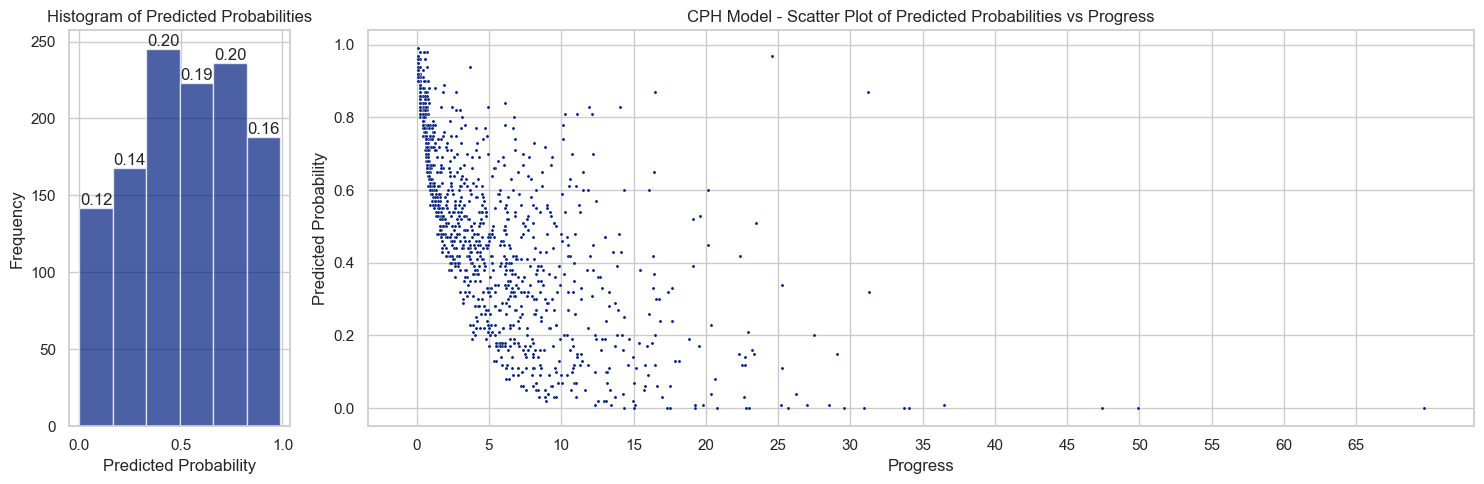

rmse: 7.113741765102735


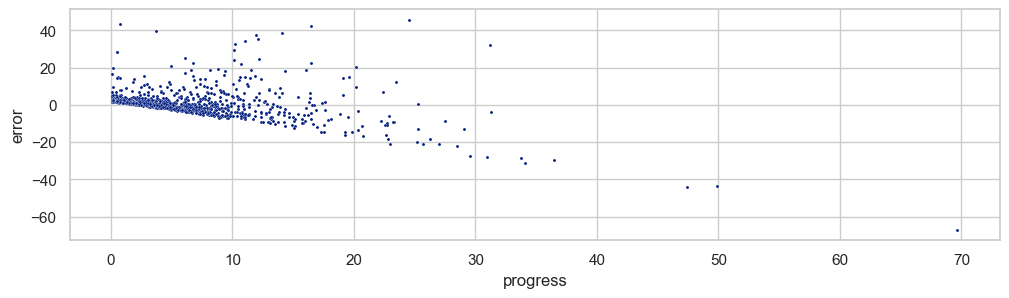

In [41]:
fit_predict(model_df, robust = True)

<lifelines.CoxPHFitter: fitted with 3770 total observations, 88 right-censored observations>
             duration col = 'progress'
                event col = 'lst_event'
      baseline estimation = breslow
   number of observations = 3770
number of events observed = 3682
   partial log-likelihood = -26033.82
         time fit was run = 2024-01-09 00:18:47 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
near_defender_MPD  -0.12       0.89       0.01            -0.14            -0.10                 0.87                 0.91
near_dist          -0.11       0.89       0.01            -0.13            -0.10                 0.88                 0.91
SoF                -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
has_blocker        -0.53       0.59       0.04            -0.61            -0.45                 0.54                 0.64

                    cmp to      z      p   -log2(p)
covariate                                          
near_defender_MPD     0.00 -11.30 <0.005      95.87
near_dist             0.00 -12.27 <0.005     112.48
SoF                   0.00 -10.40 <0.005      81.73
has_blocker           0.00 -12.79 <0.005     122.05
---
Concordance = 0.75
Partial AIC = 52075.64
log-likelihood ratio test = 1371.34 on 4 df
-log2(p) of ll-ratio test = 979.79

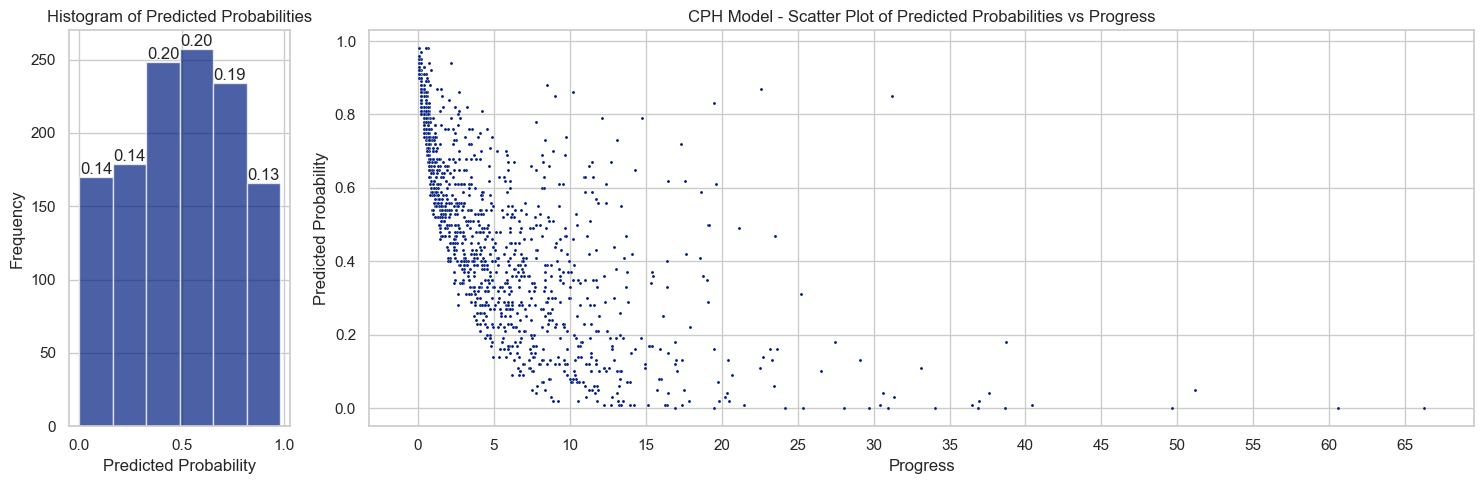

rmse: 7.261006431750991


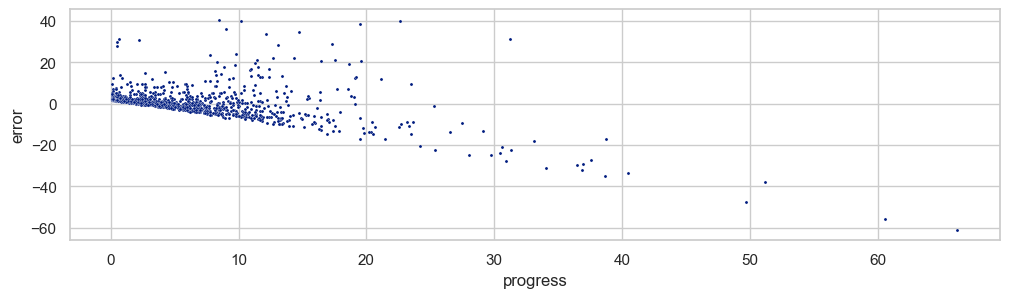

In [42]:
model_df_4f = progress_df3[['lst_event', 'progress', 'near_defender_MPD', 'near_dist', 'SoF', 'has_blocker']]
fit_predict(model_df_4f, robust = False)

<lifelines.CoxPHFitter: fitted with 3730 total observations, 87 right-censored observations>
             duration col = 'progress'
                event col = 'lst_event'
          robust variance = True
      baseline estimation = breslow
   number of observations = 3730
number of events observed = 3643
   partial log-likelihood = -25742.51
         time fit was run = 2024-01-09 00:18:52 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
near_defender_MPD  -0.12       0.88       0.01            -0.14            -0.10                 0.87                 0.90
near_dist          -0.11       0.89       0.01            -0.13            -0.09                 0.87                 0.91
SoF                -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
has_blocker        -0.49       0.61       0.04            -0.58            -0.41                 0.56                 0.66

                    cmp to      z      p   -log2(p)
covariate                                          
near_defender_MPD     0.00 -12.04 <0.005     108.48
near_dist             0.00 -11.21 <0.005      94.53
SoF                   0.00  -8.05 <0.005      50.10
has_blocker           0.00 -11.61 <0.005     101.14
---
Concordance = 0.75
Partial AIC = 51493.01
log-likelihood ratio test = 1308.75 on 4 df
-log2(p) of ll-ratio test = 934.70

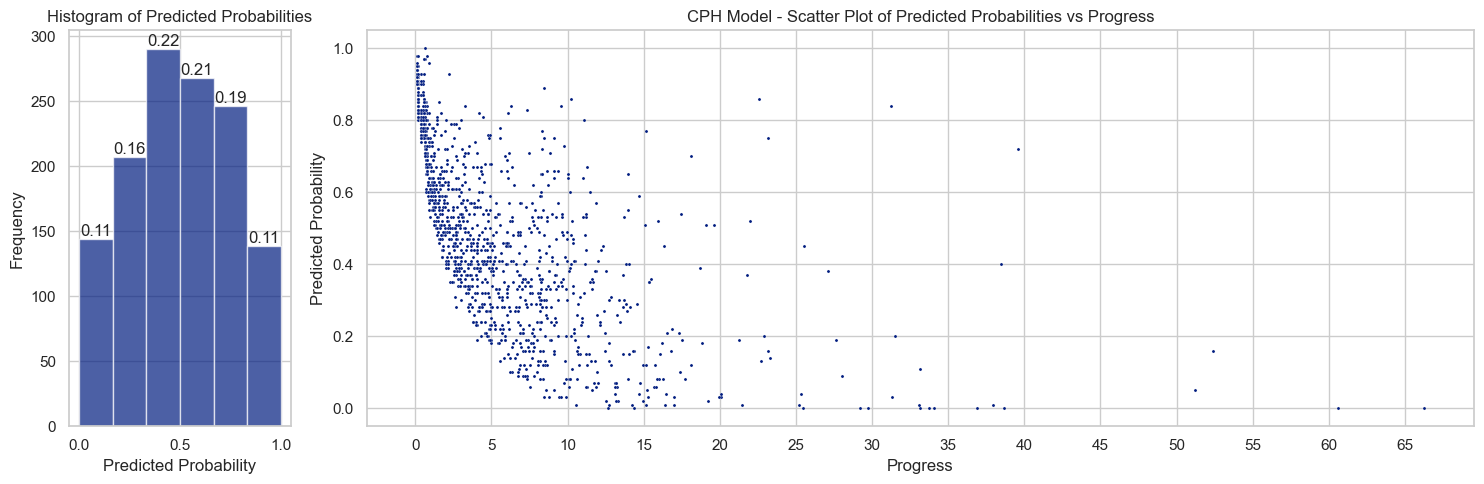

rmse: 7.23918172887356


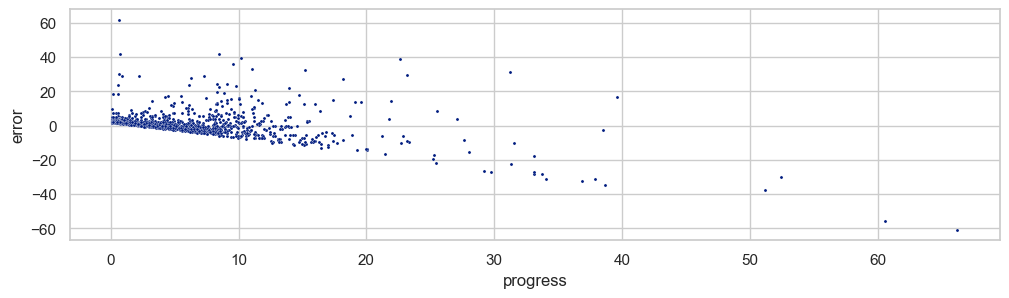

In [43]:
model_df_4f = progress_df3[['lst_event', 'progress', 'near_defender_MPD', 'near_dist', 'SoF', 'has_blocker']]
fit_predict(model_df_4f, robust = True)

Didn't observe significant difference between above models' performance. In addition, the minor differences fluctuates when each model is retained.

In [44]:
# with open('../saved_models/cph_model.pkl', 'wb') as file:
#     pickle.dump(cph_model, file)